In [1]:
%cd ~/NetBeansProjects/ExpLosion/
%load_ext autoreload
from notebooks.common_imports import *
from gui.output_utils import *

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Users/miroslavbatchkarov/NetBeansProjects/ExpLosion


# labelled size and domain- w2v @ gigaw 100 vs wiki 15 vs wiki 100

In [2]:
s = {'document_features_ev': 'SVO',
    'document_features_tr': 'J+N+V+SVO',
    'expansions__allow_overlap': 0, 
    'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
    'expansions__entries_of_id': None,
    'expansions__k': 3,
    'expansions__neighbour_strategy': 'linear',
    'expansions__noise': 0.0,
    'expansions__use_random_neighbours': 0,
    'expansions__use_similarity': 0,
    'expansions__vectors__algorithm__in': ['word2vec'],
    'expansions__vectors__composer__in': ['Verb', 'CopyObj', 'Add', 'Mult', 'FAdd', 'FMult'], 
    'expansions__vectors__dimensionality': 100,
    'expansions__vectors__rep': 0,
    'expansions__vectors__unlabelled_percentage__in': [15, 100],
    'labelled': 'amazon_grouped-tagged'}
ids = Experiment.objects.filter(**s).values_list('id', flat=True)
print(ids, 'total', len(ids))

[222, 223, 224, 227, 228, 229, 232, 233, 234, 237, 238, 239, 316, 317, 318, 321, 322, 323] total 18


Calculating CI for exp 223
Calculating CI for exp 224
Calculating CI for exp 227
Calculating CI for exp 228
Calculating CI for exp 229
Calculating CI for exp 232
Calculating CI for exp 233
Calculating CI for exp 234
Calculating CI for exp 237
Calculating CI for exp 238
Calculating CI for exp 239
Calculating CI for exp 316
Calculating CI for exp 317
Calculating CI for exp 318
Calculating CI for exp 321
Calculating CI for exp 322
Calculating CI for exp 323
algo has 9000 values
Accuracy has 9000 values
unlab has 9000 values
Composer has 9000 values
folds has 9000 values
percent has 9000 values


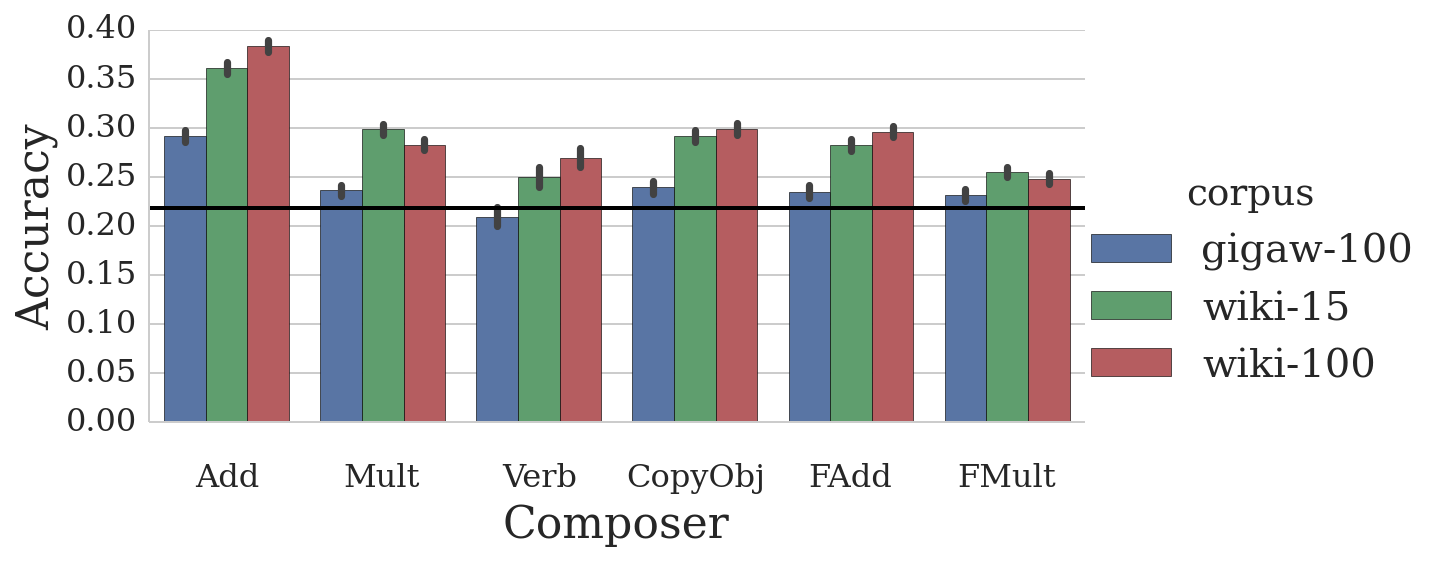

In [3]:
fields = {  'unlab': 'expansions__vectors__unlabelled',
            'algo': 'expansions__vectors__algorithm',
            'Composer': 'expansions__vectors__composer',
             'percent': 'expansions__vectors__unlabelled_percentage'}
df = dataframe_from_exp_ids(ids, fields)
df['corpus'] = ['%s-%s'%(a,b) for a,b in zip(df.unlab, df.percent)]
df.drop(['unlab', 'percent'], axis=1, inplace=True)

g= sns.factorplot(y='Accuracy', x='Composer', hue='corpus',# col='unlab', 
                  hue_order=sort_df_by(df, 'corpus'), aspect=2,
                    data=df, kind='bar', ci=68);

for ax in g.axes.flat:
    ax.axhline(random_vect_baseline(), c='k');
#     ax.axhline(nondistributional_baseline(**settings_of(ids[0])), c='k')

plt.axhline(random_vect_baseline(), c='k')
plt.savefig('plot-vps-corpus-size.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# w2v vs glove vs count @ wiki 100

[220, 221, 222, 225, 226, 227, 230, 231, 232, 235, 236, 237, 314, 315, 316, 319, 320, 321] total 18
Calculating CI for exp 220
Calculating CI for exp 221
Calculating CI for exp 225
Calculating CI for exp 226
Calculating CI for exp 230
Calculating CI for exp 231
Calculating CI for exp 235
Calculating CI for exp 236
Calculating CI for exp 314
Calculating CI for exp 315
Calculating CI for exp 319
Calculating CI for exp 320
algo has 9000 values
Accuracy has 9000 values
folds has 9000 values
Composer has 9000 values


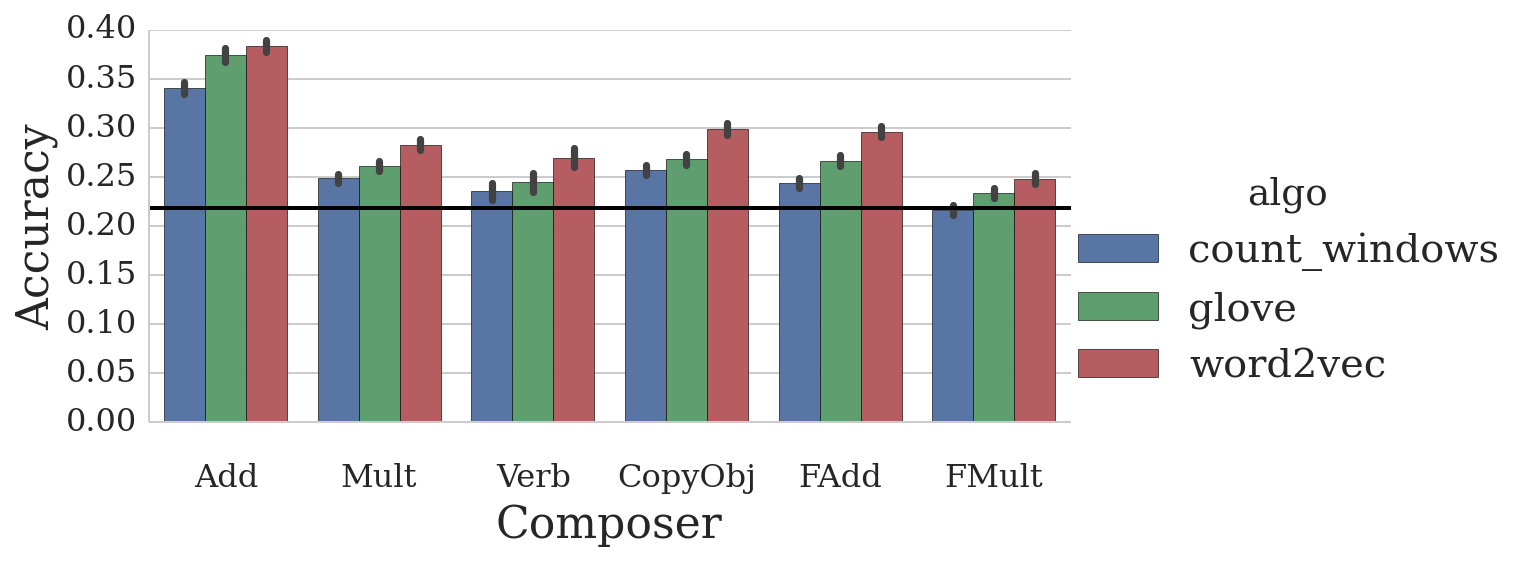

In [4]:
s['expansions__vectors__algorithm__in'] = ['word2vec', 'glove', 'count_windows']
s['expansions__vectors__composer__in'] = ['Verb', 'CopyObj', 'Add', 'Mult', 'FAdd', 'FMult']
s['expansions__vectors__unlabelled'] = 'wiki'
s['expansions__vectors__unlabelled_percentage__in'] = [100]
ids = Experiment.objects.filter(**s).values_list('id', flat=True)
print(ids, 'total', len(ids))

fields = {'algo': 'expansions__vectors__algorithm',
          'Composer': 'expansions__vectors__composer'
}
df = dataframe_from_exp_ids(ids, fields, abbreviate=False)
g= sns.factorplot(y='Accuracy', x='Composer', hue='algo', 
                   data=df, kind='bar', aspect=2, ci=68);
plt.axhline(random_vect_baseline(), c='k')
plt.savefig('plot-vps-algorithm.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)